In [109]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# PREPROCESSING

In [110]:
marketing_df = pd.read_csv('marketing_campaign.csv', delimiter = '\t')

marketing_df.head(20)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,09-09-2013,16,520,...,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,13-11-2012,34,235,...,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,08-05-2013,32,76,...,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,06-06-2013,19,14,...,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,13-03-2014,68,28,...,20,1,0,0,0,0,0,3,11,0


In [111]:
#1. Cleaning up null values
#2. Data cleaning (dashes, odd characters, etc)
#3. Remove extreme outliers
#4. One-Hot encoding
#5. Convert Categorical values to numerical (sometimes that is the same as 3)
#6. Standardization/Normalization
#7. Deal with multicollinearity (can be caused by 3)

# Miscellaneous null cleaning
def null_sub(df: DataFrame = marketing_df) -> DataFrame:
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:  # Numerical columns
            median = df[col].median()
            df[col] = df[col].fillna(median)
        elif df[col].dtype == 'object':  # Categorical columns
            if not df[col].isna().all():
                mode = df[col].mode().iloc[0]
                df[col] = df[col].fillna(mode)
    return df

marketing_df = null_sub()

# Clean up odd characters
def clean_char(df: DataFrame = marketing_df) -> DataFrame:
    for col in df.columns:
        if df[col].dtype == 'object':  # Categorical columns
            df[col] = df[col].str.strip()
            df[col] = df[col].str.replace('-', ' ')
    return df

marketing_df = clean_char()

# One-Hot Encoding
def encode(df: DataFrame = marketing_df) -> DataFrame:
    for col in df.columns:
        if df[col].dtype == 'object':  # Categorical columns
            temp = pd.get_dummies(df[col], drop_first=True)
            df = df.drop(columns=[col])
            df = df.join(temp)
    return df

marketing_df = encode()

# Standardize
def stdData(df: DataFrame = marketing_df) -> DataFrame:
    sc = StandardScaler()
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            df[[col]] = sc.fit_transform(df[[col]])

    return df

marketing_df = stdData()

Above, I handled null values by checking each column for the data type its dealing with, and replaced NaN values accordingly. For numerical columns, replacing with the median makes sense, and for categorical columns, I used the mode for consistency and cohesion. In addition, I one-hot encoded all categorical columns after cleaning up any odd characters and whitespace, followed by standardizing the remaining numerical columns.

# K-MEANS

In [112]:
def kmeans(df: DataFrame = marketing_df) -> DataFrame: 
    # Select relevant features for clustering from the marketing dataframe
    segments = marketing_df[['Year_Birth', 'Income', 'MntWines', 'MntMeatProducts', 'NumWebPurchases', 'NumStorePurchases']]
    inertia = {} # Empty dictionary to store inertia values, clusters are keys, inertia values are, well, values
    cluster_range = range(1, 21) # Arbitrary range of values to test, akin to the model optimization from Homework 10
    for k in cluster_range:
        kmeans = KMeans(n_clusters = k, random_state = 42)
        kmeans.fit(segments)
        inertia[k] = kmeans.inertia_ # Add inertia value to the cluster key in the dictionoary

    return inertia

inertia_dict = kmeans()

print(inertia_dict)

{1: 13440.0, 2: 7999.367486598752, 3: 6816.2406122907205, 4: 6156.55730890493, 5: 5586.127231071243, 6: 5162.760712512091, 7: 4846.549432790438, 8: 4574.371408286748, 9: 4411.440516186212, 10: 3846.512834648537, 11: 3665.7343105592104, 12: 3533.868281143611, 13: 3378.813809914566, 14: 3257.5250234636314, 15: 3079.932666260197, 16: 3005.465470149165, 17: 2949.395464845527, 18: 2865.2738243048398, 19: 2716.958898754924, 20: 2678.0346948813403}


Feature selection is an important part of data science, and, in this way, examining the most pivotal parts of data can help streamline data processing and structural management. Above, you can see that I picked out the most pressing segments for analysis: age (gathered from their birthyear), income, monthly products bought, and web and store purchases. Clustering from these segments allowed a simpler cluster optimization approach, as I could simply look at k values where inertia values showed a drastic decrease; namely, around 3 - 4 clusters as well as 9 - 10 clusters, making them optimal for this dataset.

# HIERARCHICAL CLUSTERING

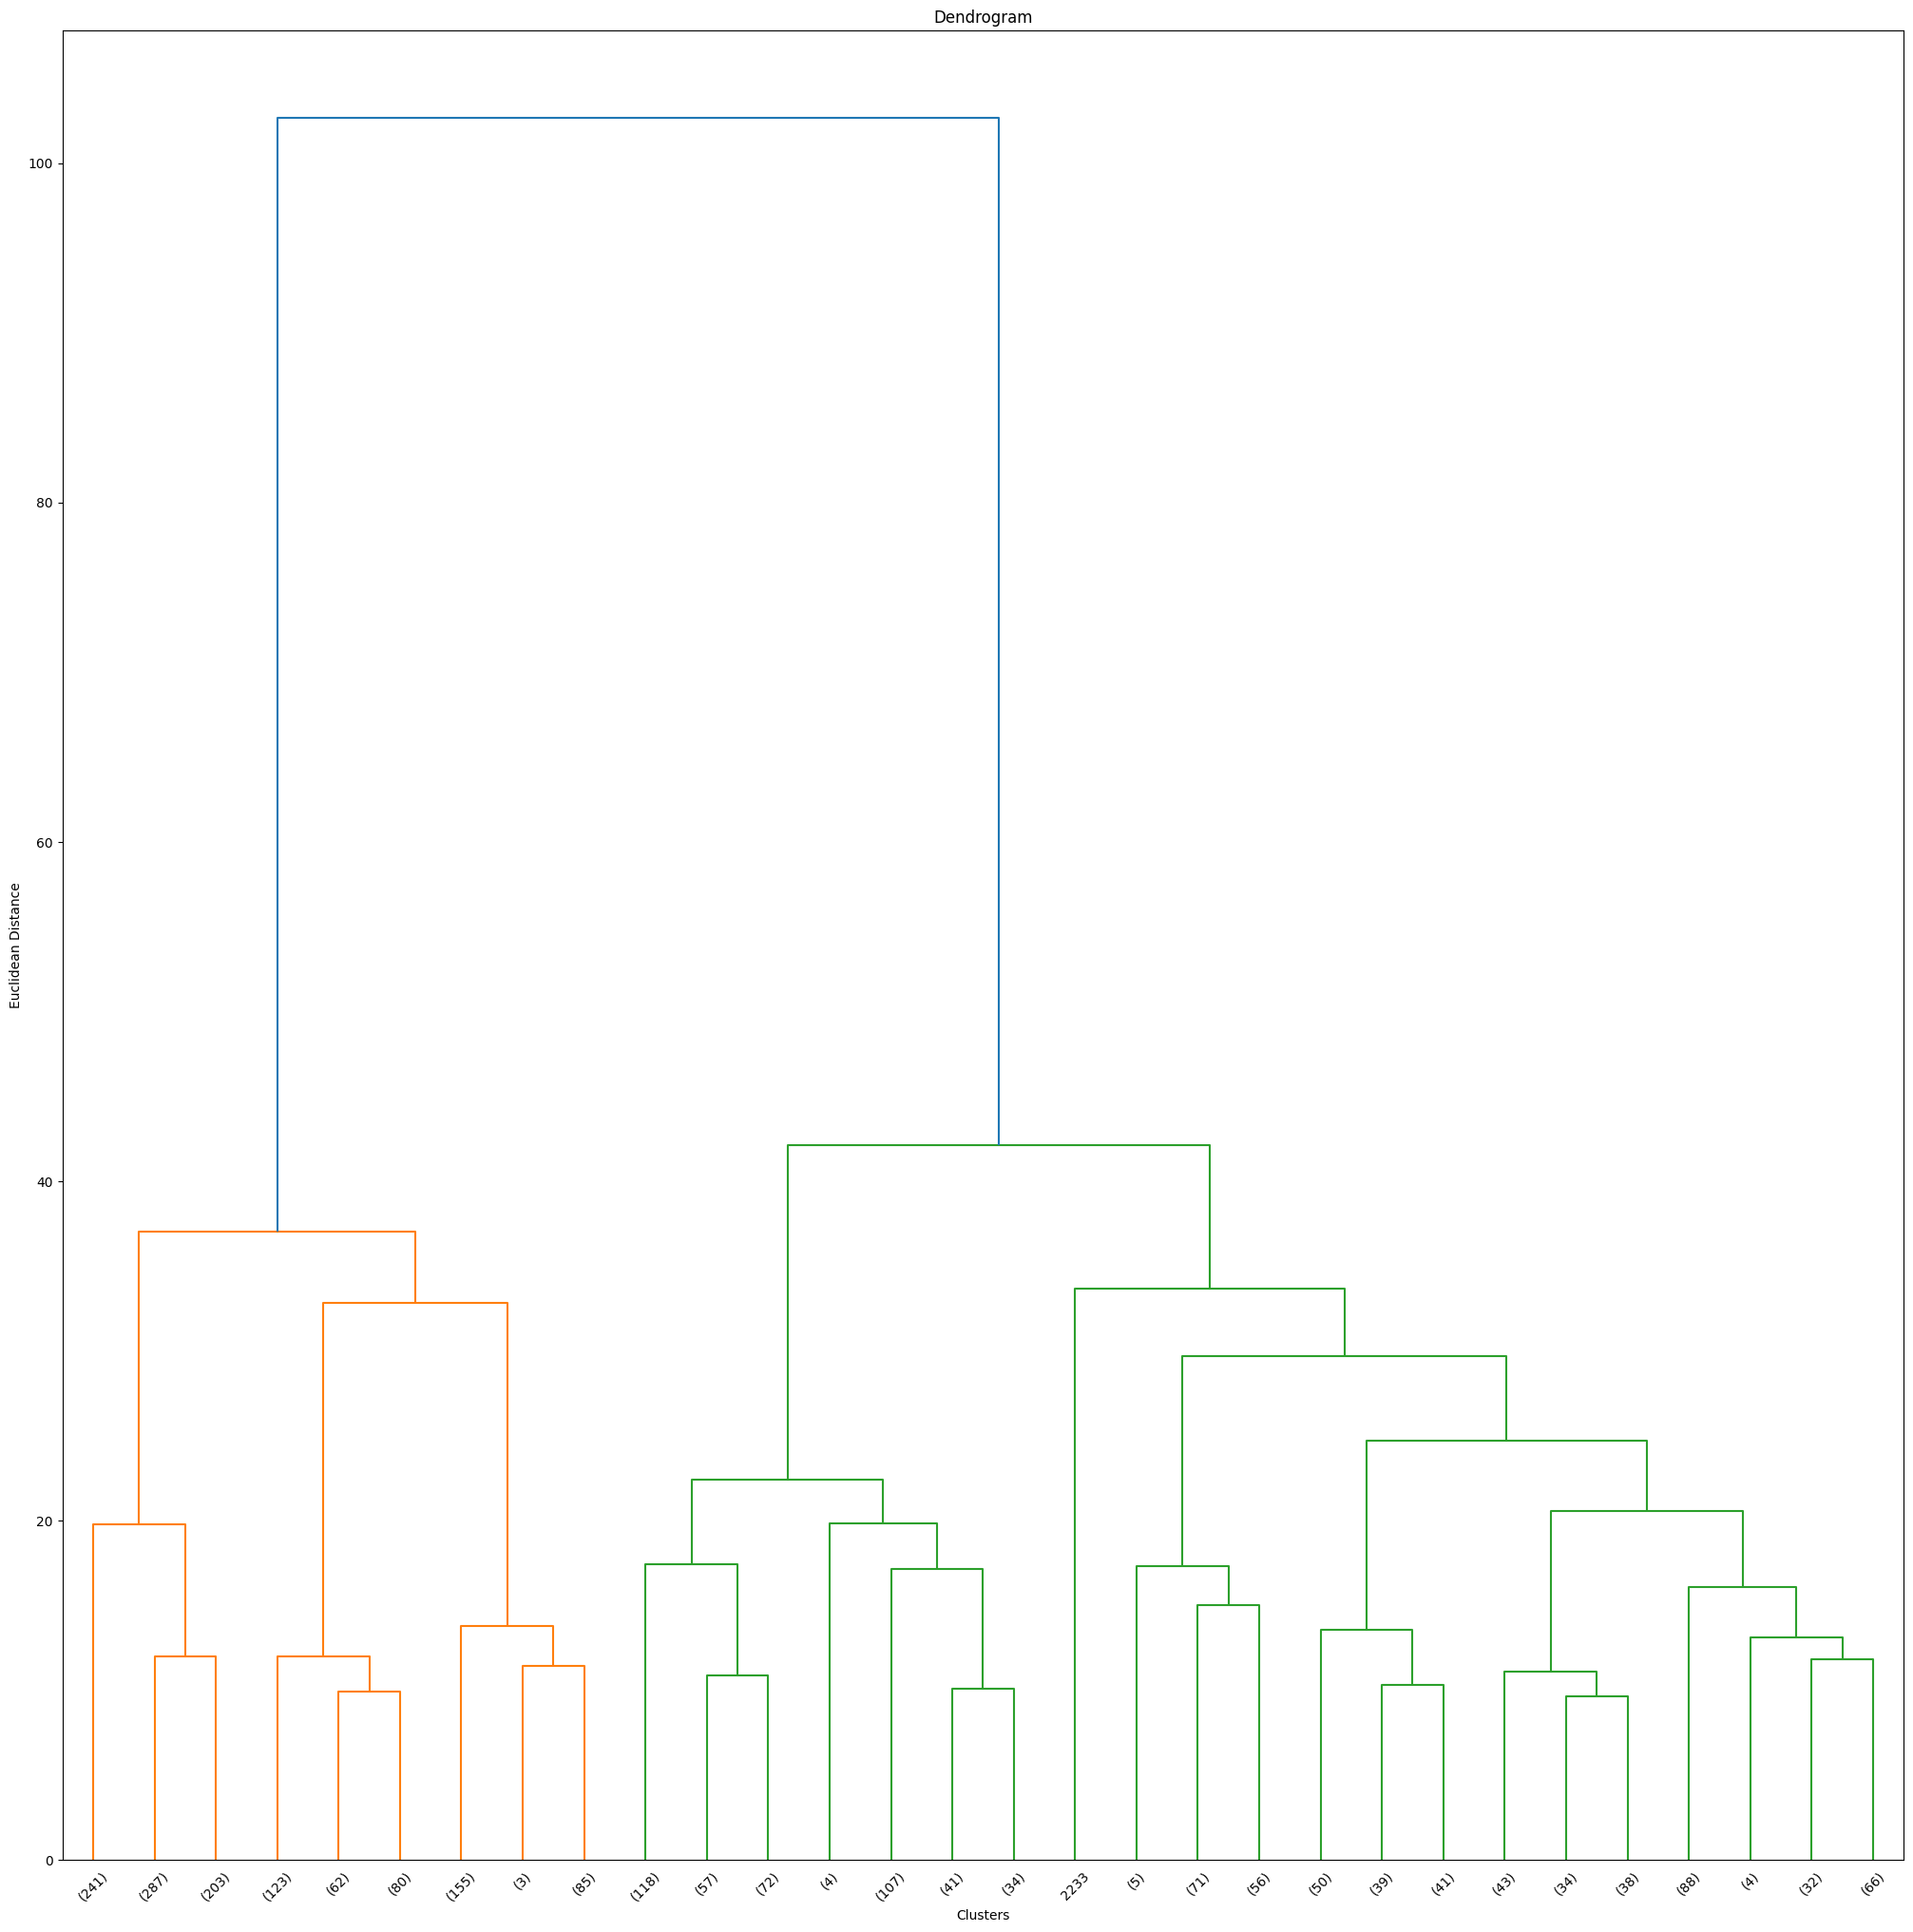

In [113]:
def hierClustering(df: DataFrame = marketing_df) -> DataFrame: 
    # Select relevant features for clustering from the marketing dataframe
    segments = marketing_df[['Year_Birth', 'Income', 'MntWines', 'MntMeatProducts', 'NumWebPurchases', 'NumStorePurchases']]
    
    linked = linkage(segments, method = 'ward')

    return linked

cluster = hierClustering()

plt.figure(figsize = (25, 25))
dendrogram(cluster, truncate_mode = 'lastp') # Truncate is important to not overrun the graph with unnecessary p values.
plt.xlabel("Clusters")
plt.ylabel("Euclidean Distance")
plt.title("Dendrogram")
plt.show()

After doing some online research, I found out that dendograms are best-suited to represent hierarchical clustering models; what we are looking at in the graph above is a representation of the euclidean distance (essentially the effectiveness) of different cluster sizes, with there being a general trend toward smaller clusters being a bit more accurate. This is to be expected for datasets that are relatively simple and standardized, but there still seems to be viability in using larger cluster hierarchies.

# Final Thoughts

I think that K-Means is a better unsupervised learning approach. It is far less complex to visualize and implement; in addition, it also easier to optimize and tweak, with there being a little more transparency stemming from the fact that the number of clusters is up to the programmer's disrection. Hierarchical clustering seems to be better-suited to gain a high-level comprehension of strategies that would be suited to process a dataset, but relatively complex for the tasks we are concerned with, at the moment.